<a href="https://colab.research.google.com/github/xcsengody/DP/blob/master/Notebooks/MachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip -q install parfit

import sys
from google.colab import drive

print("\nGoogle Drive File Stream Authentication\n")
drive.mount('/content/drive',force_remount=True)
sys.path.append('/content/drive/My Drive')
sys.path.append('/content/drive/My Drive/Colab Notebooks/Notebooks')

from lib.Config import *
from lib.MachineLearningController import *

def saveDocument(fileName):
  !jupyter nbconvert --log-level 0 --output {fileName} --output-dir='drive/My Drive/Colab Notebooks/Documents' "drive/My Drive/Colab Notebooks/Notebooks/MachineLearning.ipynb"
  print("File saved to .../Colab Notebooks/Documents/{}.html".format(fileName))

In [0]:
saveDocument("dataset_4_MAP_RESAMP_TOPF_T")

In [0]:
datasetsToLoad = ['dataset_4_MAP_RESAMP.csv','dataset_4_MAP.csv']
datasetsToMerge = []
modelPrefix = ''
selectTopFeatures=True
OHE=False

In [3]:
loadPreprocessedDatasets(dataset_preprocessed_path,datasetsToLoad)

Datasets:
dataset_4_MAP_RESAMP
Rows: 702296
Columns: 50

dataset_4_MAP
Rows: 440042
Columns: 50


To access dataset use datasets['datasetName']



In [9]:
#dataset = mergeDatasets(list(datasets))

Handle datasets with different dimensions


In [0]:
df=datasets['dataset_4_MAP_RESAMP']

In [5]:
X_train, y_train, X_valid, y_valid, X_test, y_test = splitDataset(df)

Train set size: 449468
Validation set size: 112368
Test set size: 140460



DATASET NAME
Total rows: 702296
Total features: 50
Normal traffic: 351148 (50.0 %)
Attack traffic: 351148 (50.0 %)





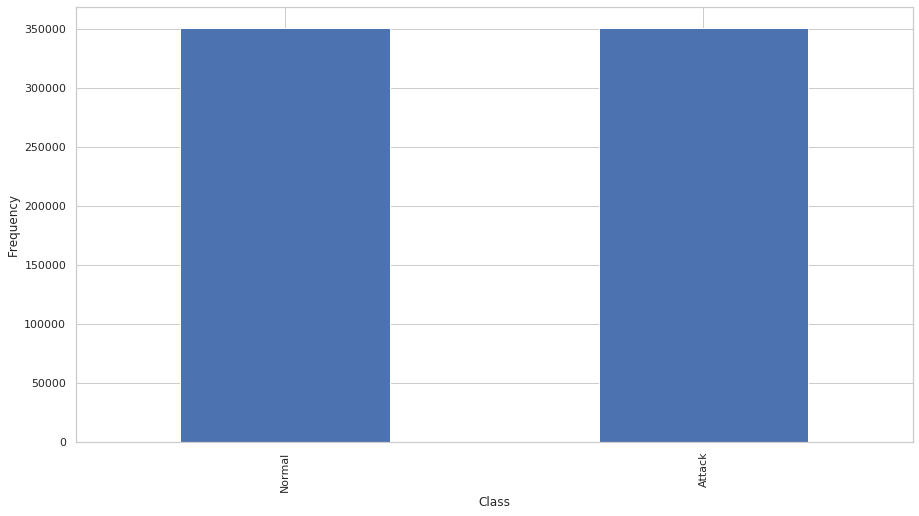

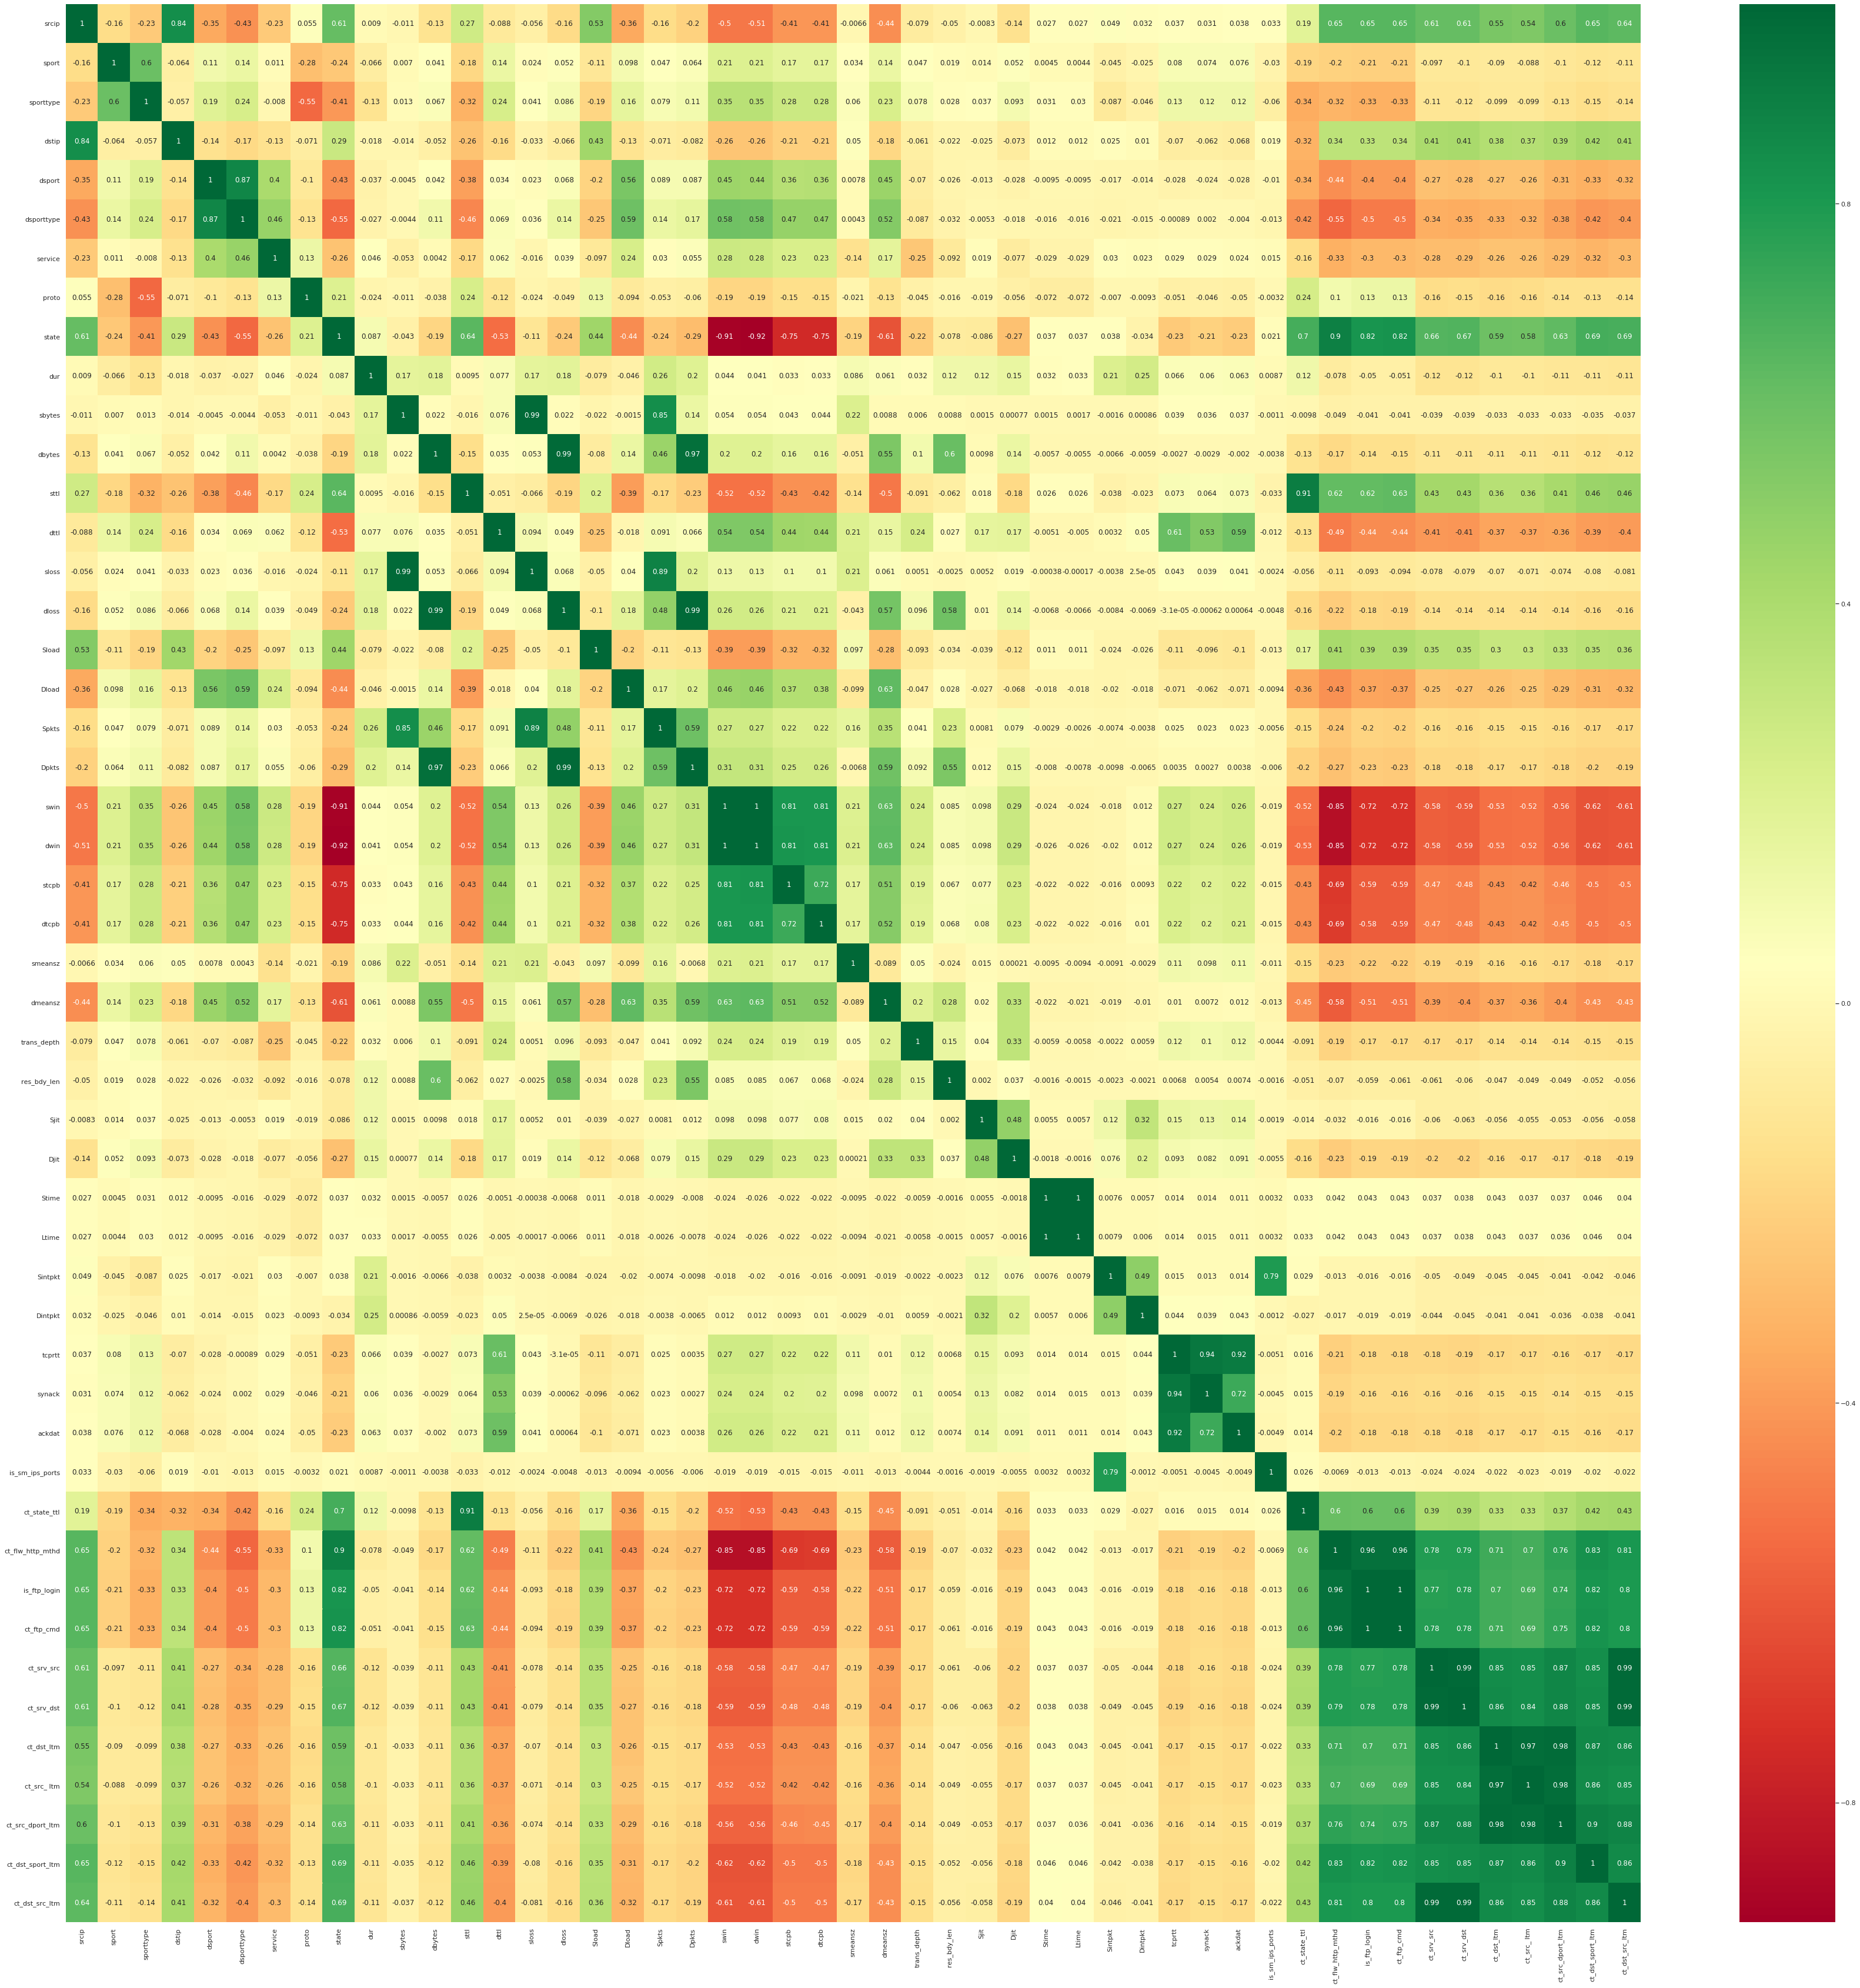

In [6]:
analyzeDataset(df)
getCorelationMatrix(X_train)

In [0]:
# ---> Logistic Regression <---

In [0]:
logisticRegression_model = LogisticRegression()
rfe = RFE(logisticRegression_model, n_features_to_select=None, step=8, verbose=2)
rfe.fit(X_train, y_train)

selected_columns=[]
columns = X_train.columns
ranked_columns = rfe.support_

for i in range(len(ranked_columns)):
  if ranked_columns[i] == True:
    selected_columns.append(columns[i])

print("Number of selected columns: {}\n",format(len(selected_columns)))

In [28]:
print(selected_columns)

['srcip', 'dstip', 'dsport', 'proto', 'state', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'Dload', 'Dpkts', 'swin', 'dwin', 'dmeansz', 'Djit', 'Dintpkt', 'synack', 'ct_state_ttl', 'ct_flw_http_mthd', 'ct_ftp_cmd', 'ct_srv_dst', 'ct_dst_sport_ltm', 'ct_dst_src_ltm']


In [35]:
X_train_logreg=X_train[selected_columns]
X_valid_logreg=X_valid[selected_columns]
X_test_logreg=X_test[selected_columns]

try:
  logReg_selectedAttributes=sm.Logit(y_train,X_train_logreg)
  logisticRegression_selectedAttributes=logReg_selectedAttributes.fit()
except np.linalg.LinAlgError as err:
  print("\nIndependent attributes are correlated, which lead to singular matrix.\n"+
        "Remove any attribute that seems that would  be perfectly corelated.\n")
  selected_columns = ['srcip', 'dstip', 'dsport', 'proto', 'state', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'Dload', 'Dpkts', 'Dintpkt', 'synack', 'ct_state_ttl', 'ct_flw_http_mthd', 'ct_ftp_cmd', 'ct_srv_dst', 'ct_dst_sport_ltm', 'ct_dst_src_ltm']
  
  X_train_logreg=X_train[selected_columns]
  X_valid_logreg=X_valid[selected_columns]
  X_test_logreg=X_test[selected_columns]

  logReg_selectedAttributes=sm.Logit(y_train,X_train_logreg)
  logisticRegression_selectedAttributes=logReg_selectedAttributes.fit()

print(logisticRegression_selectedAttributes.summary2())

Optimization terminated successfully.
         Current function value: 0.034337
         Iterations 23
                           Results: Logit
Model:                Logit            Pseudo R-squared: 0.950      
Dependent Variable:   label            AIC:              30906.7067 
Date:                 2019-12-07 22:33 BIC:              31127.0231 
No. Observations:     449468           Log-Likelihood:   -15433.    
Df Model:             19               LL-Null:          -3.1155e+05
Df Residuals:         449448           LLR p-value:      0.0000     
Converged:            1.0000           Scale:            1.0000     
No. Iterations:       23.0000                                       
--------------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|   [0.025   0.975] 
--------------------------------------------------------------------
srcip             15.6476   0.3397  46.0655 0.0000  14.9819  16.3134
dstip            -60.7321  

In [0]:
params = {'penalty': ['l2'],
         'dual': [False],
         'C':[.005,0.01,1,5],
         'solver': ['lbfgs','saga'],
         'max_iter': [100,500],
         'multi_class': ['ovr','auto'],
         'warm_start': [True,False]}

logisticRegression_model = LogisticRegression()
logisticRegression_gridSearch = GridSearchCV(logisticRegression_model, param_grid = params, cv = 10, n_jobs=-1, verbose=2)

if selectTopFeatures:
  logisticRegression_gridSearch = logisticRegression_gridSearch.fit(X_train_logreg, y_train)
else:
  logisticRegression_gridSearch = logisticRegression_gridSearch.fit(X_train, y_train)

pprint(logisticRegression_gridSearch.best_params_)

Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.


In [0]:
logisticRegression_model = LogisticRegression(**logisticRegression_gridSearch.best_params_)

if selectTopFeatures:
  logisticRegression = logisticRegression_model.fit(X_train_logreg, y_train)
  predict(logisticRegression, X_valid_logreg, y_valid,"Validation set prediction")
  predict(logisticRegression, X_test_logreg, y_test,"Test set prediction")
  saveModel(logisticRegression,machineLearningModels_path,modelPrefix+'_LogisticRegression_SelectedFeatures')
else:
  logisticRegression = logisticRegression_model.fit(X_train, y_train)
  predict(logisticRegression, X_valid, y_valid,"Validation set prediction")
  predict(logisticRegression, X_test, y_test,"Test set prediction")
  saveModel(logisticRegression,machineLearningModels_path,modelPrefix+'_LogisticRegression')

In [0]:
# ---> SCV <---

In [0]:
grid = {'alpha': [1e-2, 1e-1, 1e0, 1e1, 1e2],
        'max_iter': [500],
        'loss': ['log', 'modified_huber', 'squared_hinge', 'perceptron'],
        'learning_rate': ['constant', 'invscaling', 'adaptive'],
        'eta0': [0.2],
        'fit_intercept': [True,False],
        'shuffle': [True,False],
        'early_stopping': [True,False],
        'penalty': ['l2','elasticnet'],
        'n_jobs': [-1]}

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 101 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 185 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 285 tasks      | elapsed:  

-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 370 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 720 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:   16.6s finished


Too many dimensions to plot.


Validation set prediction


Accuracy: 49.66%

Standard 10 x Cross-validation accuracy: 0.695530 (+/- 0.324415)
Stratified 10 x K-fold Cross-validation accuracy: 0.690423 (+/- 0.333623)


Classification Report
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     56566
           1       0.50      1.00      0.66     55802

    accuracy                           0.50    112368
   macro avg       0.25      0.50      0.33    112368
weighted avg       0.25      0.50      0.33    112368



Confusion-matrix
 Predicted Species      1
Actual Species          
0                  56566
1                  55802



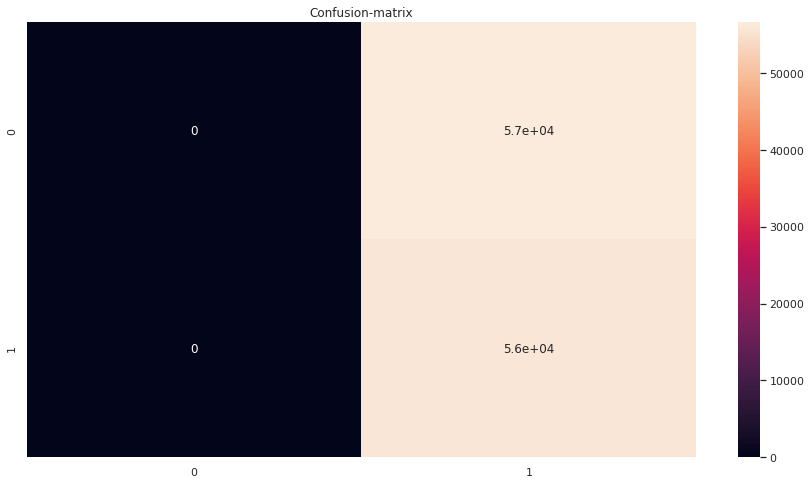

<Figure size 1440x1440 with 0 Axes>


ROC-AUC: 0.3366152868211585



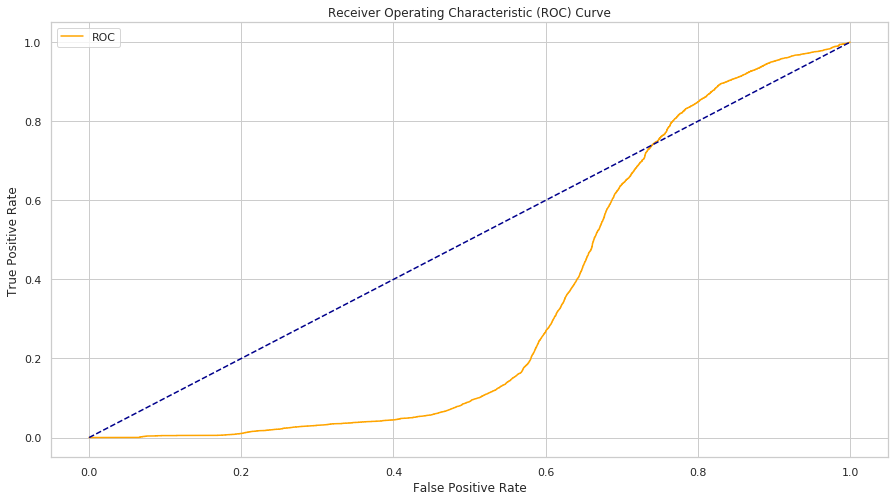





Test set prediction


Accuracy: 50.10%

Standard 10 x Cross-validation accuracy: 0.605586 (+/- 0.493176)
Stratified 10 x K-fold Cross-validation accuracy: 0.640955 (+/- 0.430715)


Classification Report
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     70087
           1       0.50      1.00      0.67     70373

    accuracy                           0.50    140460
   macro avg       0.25      0.50      0.33    140460
weighted avg       0.25      0.50      0.33    140460



Confusion-matrix
 Predicted Species      1
Actual Species          
0                  70087
1                  70373



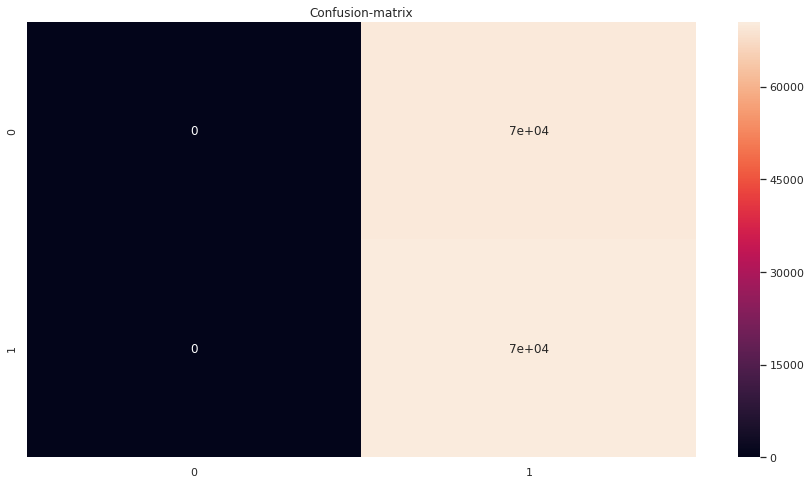

<Figure size 1440x1440 with 0 Axes>


ROC-AUC: 0.2953316845812221



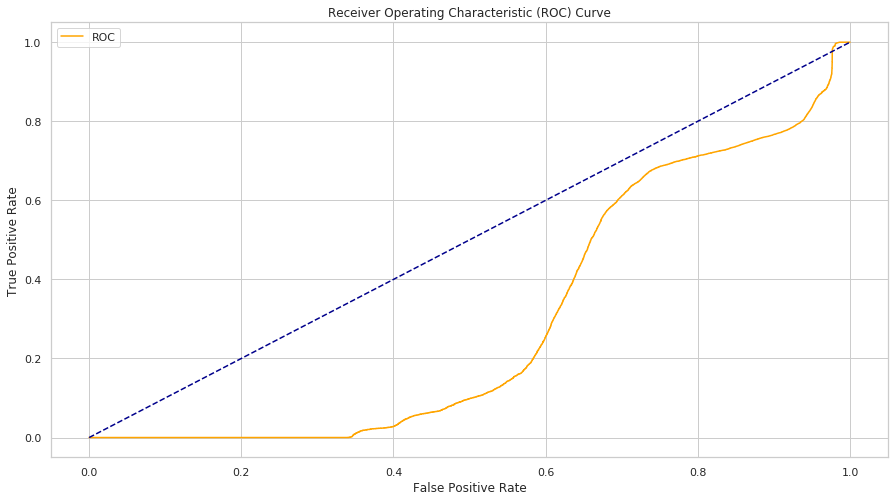

TypeError: ignored

In [0]:
if selectTopFeatures:
  feature_map_nystroem = Nystroem(random_state=0,n_components=10)
  X_train_svc = feature_map_nystroem.fit_transform(X_train)
  X_test_svc = feature_map_nystroem.fit_transform(X_test)
  X_valid_svc = feature_map_nystroem.fit_transform(X_valid)

  paramGrid = ParameterGrid(grid)
  SGDClassifier_model = linear_model.SGDClassifier()
  bestModel_SGDClassifier, bestScore_SGDClassifier, allModels, allScores = pf.bestFit(SGDClassifier_model, paramGrid,
                                                                                      X_train_svc, y_train, X_valid_svc, y_valid, 
                                                                                      metric = roc_auc_score, scoreLabel = 'AUC')
  SGDClassifier_model = bestModel_SGDClassifier
  SGDClassifier = SGDClassifier_model.fit(X_train_svc, y_train)
  predict(SGDClassifier, X_valid_svc, y_valid,"Validation set prediction")
  predict(SGDClassifier, X_test_svc, y_test,"Test set prediction")
  saveModel(SGDClassifier,machineLearningModels_path,modelPrefix+'_SGDClassifier')
else:
  paramGrid = ParameterGrid(grid)
  SGDClassifier_model = linear_model.SGDClassifier()
  bestModel_SGDClassifier, bestScore_SGDClassifier, allModels, allScores = pf.bestFit(SGDClassifier_model, paramGrid,
                                                                                      X_train, y_train, X_valid, y_valid, 
                                                                                      metric = roc_auc_score, scoreLabel = 'AUC')
  SGDClassifier_model = bestModel_SGDClassifier
  SGDClassifier = SGDClassifier_model.fit(X_train, y_train)
  predict(SGDClassifier, X_valid, y_valid,"Validation set prediction")
  predict(SGDClassifier, X_test, y_test,"Test set prediction")
  saveModel(SGDClassifier,machineLearningModels_path,modelPrefix+'_SGDClassifier')

In [0]:
# ---> Decision Tree <---


Random Search

{'criterion': ['gini', 'entropy'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt', 'log2'],
 'min_samples_leaf': [2, 4, 6, 8, 10],
 'min_samples_split': [5, 10, 15, 20],
 'splitter': ['best', 'random']}


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 out of 100 | elapsed:    7.5s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.4s finished



Grid Search

{'criterion': ['entropy'],
 'max_depth': [50, 53, 56, 60],
 'max_features': ['sqrt'],
 'min_samples_leaf': [6, 9, 12, 16],
 'min_samples_split': [10, 13, 16, 20],
 'splitter': ['best']}


Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.6s finished



Hyperparameters

{'criterion': 'entropy',
 'max_depth': 50,
 'max_features': 'sqrt',
 'min_samples_leaf': 6,
 'min_samples_split': 16,
 'splitter': 'best'}

Selected features: Index(['dsport', 'ct_state_ttl'], dtype='object')

Random Search

{'criterion': ['gini', 'entropy'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt', 'log2'],
 'min_samples_leaf': [2, 4, 6, 8, 10],
 'min_samples_split': [5, 10, 15, 20],
 'splitter': ['best', 'random']}


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 out of 100 | elapsed:    5.1s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.4s finished



Grid Search

{'criterion': ['gini'],
 'max_depth': [50, 53, 56, 60],
 'max_features': ['sqrt'],
 'min_samples_leaf': [8, 11, 14, 18],
 'min_samples_split': [10, 13, 16, 20],
 'splitter': ['best']}


Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:    6.4s finished



Hyperparameters

{'criterion': 'gini',
 'max_depth': 60,
 'max_features': 'sqrt',
 'min_samples_leaf': 14,
 'min_samples_split': 16,
 'splitter': 'best'}


Validation set prediction


Accuracy: 98.71%

Standard 10 x Cross-validation accuracy: 0.998033 (+/- 0.001928)
Stratified 10 x K-fold Cross-validation accuracy: 0.998375 (+/- 0.001018)


Classification Report
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     56566
           1       0.98      1.00      0.99     55802

    accuracy                           0.99    112368
   macro avg       0.99      0.99      0.99    112368
weighted avg       0.99      0.99      0.99    112368



Confusion-matrix
 Predicted Species      0      1
Actual Species                 
0                  55300   1266
1                    181  55621



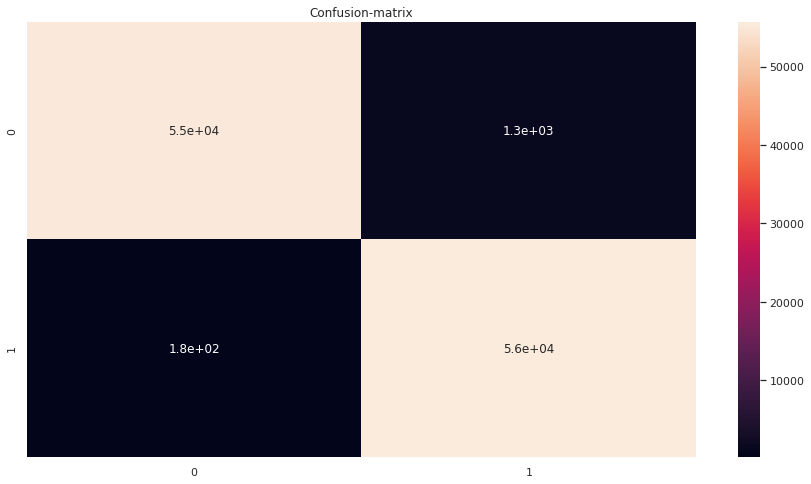

<Figure size 1440x1440 with 0 Axes>


ROC-AUC: 0.998742991093454



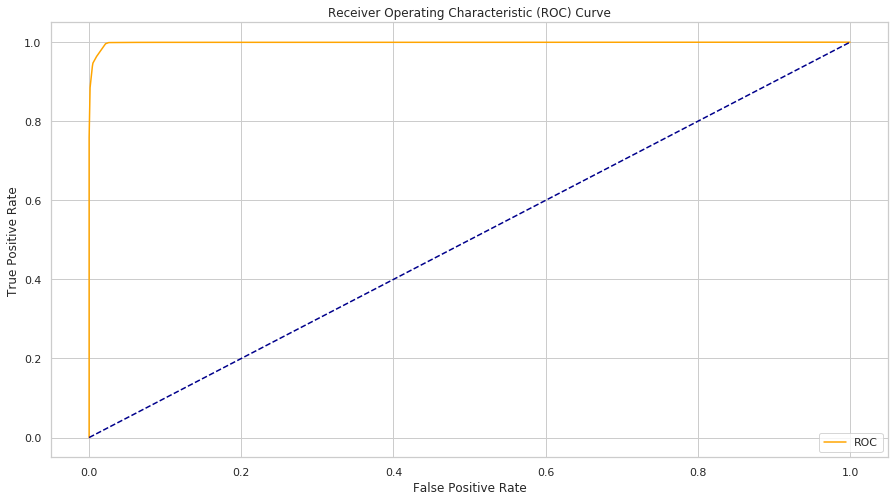





Test set prediction


Accuracy: 98.71%

Standard 10 x Cross-validation accuracy: 0.997133 (+/- 0.003345)
Stratified 10 x K-fold Cross-validation accuracy: 0.998551 (+/- 0.001058)


Classification Report
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     70087
           1       0.98      1.00      0.99     70373

    accuracy                           0.99    140460
   macro avg       0.99      0.99      0.99    140460
weighted avg       0.99      0.99      0.99    140460



Confusion-matrix
 Predicted Species      0      1
Actual Species                 
0                  68479   1608
1                    203  70170



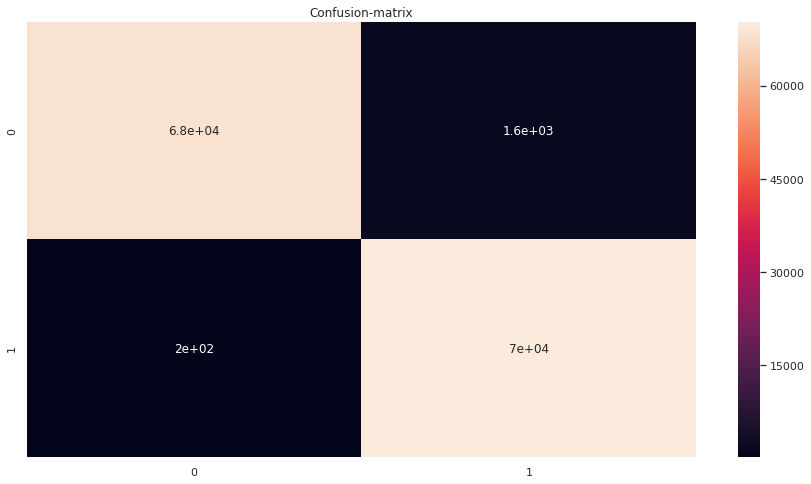

<Figure size 1440x1440 with 0 Axes>


ROC-AUC: 0.9987884672793983



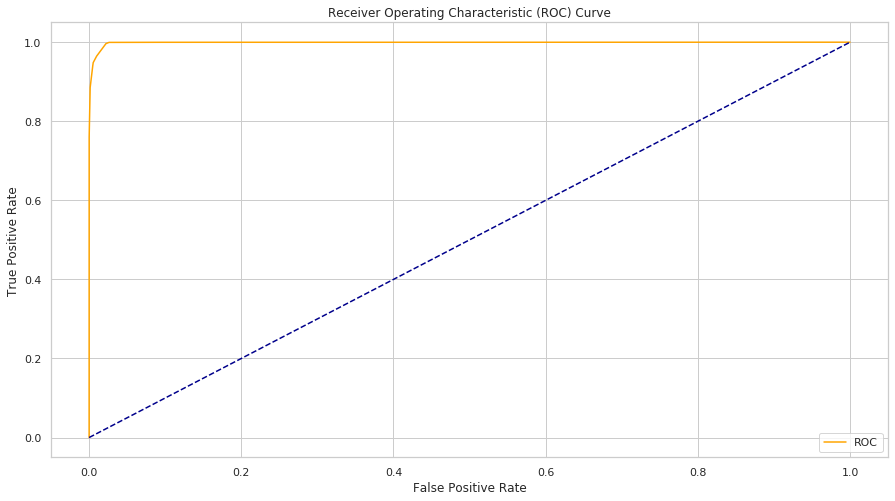



Model saved to .../Colab Notebooks/MachineLearningModels/_DecisionTree_SelectedFeatures.sav



In [0]:
if OHE:
  decisionTreeModel = DecisionTreeClassifier()
else:
  hyperparameters = TreeBasedModelHyperparameterSelector(X_train, y_train, randomForest=False)
  decisionTreeModel = DecisionTreeClassifier(**hyperparameters)

if selectTopFeatures:
  selected_features = SelectFromModel(decisionTreeModel)
  selected_features.fit(X_train, y_train)
  features = X_train.columns[(selected_features.get_support())]
  X_train_decisionTree = selected_features.transform(X_train)
  X_valid_decisionTree = selected_features.transform(X_valid)
  X_test_decisionTree = selected_features.transform(X_test)
  print("\nSelected features: {}".format(features))

  hyperparameters = TreeBasedModelHyperparameterSelector(X_train_decisionTree, y_train, randomForest=False)
  decisionTreeModel = DecisionTreeClassifier(**hyperparameters)
  decisionTree = decisionTreeModel.fit(X_train_decisionTree, y_train)
  predict(decisionTree, X_valid_decisionTree, y_valid,"Validation set prediction")
  predict(decisionTree, X_test_decisionTree, y_test,"Test set prediction")
  saveModel(decisionTree,machineLearningModels_path,modelPrefix+'_DecisionTree_SelectedFeatures')
else:
  decisionTree = decisionTreeModel.fit(X_train, y_train)
  predict(decisionTree, X_valid, y_valid,"Validation set prediction")
  predict(decisionTree, X_test, y_test,"Test set prediction")
  saveModel(decisionTree,machineLearningModels_path,modelPrefix+'_DecisionTree')

In [0]:
# ---> Random Forest <---

In [0]:
if OHE:
  randomForestModel = RandomForestClassifier()
else:
  hyperparameters = TreeBasedModelHyperparameterSelector(X_train, y_train, randomForest=True)
  randomForestModel = RandomForestClassifier(**hyperparameters)

if selectTopFeatures:
  selected_features = SelectFromModel(randomForestModel)
  selected_features.fit(X_train, y_train)
  features = X_train.columns[(selected_features.get_support())]
  X_train_randForest = selected_features.transform(X_train)
  X_test_randForest = selected_features.transform(X_test)
  X_valid_randForest = selected_features.transform(X_valid)
  print("\nSelected features: {}".format(features))

  hyperparameters = TreeBasedModelHyperparameterSelector(X_train_randForest, y_train, randomForest=True)
  randomForestModel = RandomForestClassifier(**hyperparameters)
  randomForest = randomForestModel.fit(X_train_randForest, y_train)
  predict(randomForest, X_valid_randForest, y_valid,"Validation set prediction")
  predict(randomForest, X_test_randForest, y_test,"Test set prediction")
  saveModel(randomForest,machineLearningModels_path,modelPrefix+'_RandomForest_SelectedFeatures')
else:
  randomForest = randomForestModel.fit(X_train, y_train)
  predict(randomForest, X_valid, y_valid,"Validation set prediction")
  predict(randomForest, X_test, y_test,"Test set prediction")
  saveModel(randomForest,machineLearningModels_path,modelPrefix+'_RandomForest')

In [0]:
'''
# KNN

error = []
range_form = 1
range_to = 20

for i in range(range_form, range_to):
  KNN = KNeighborsClassifier(n_neighbors=i)
  print("Set KNN")
  KNN.fit(X_train, y_train)
  print("Fitted KNN")
  pred_i = KNN.predict(X_test)
  print("Prediction: .lf%%" % pred_i)
  error.append(np.mean(pred_i != y_test))

plt.plot(range(1, 2), error, color='green', marker='o', markerfacecolor='orange', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

KNN = KNeighborsClassifier(n_neighbors=???)
clf = KNN.fit(X_train, y_train)

predict(clf, X_train, y_train, X_test, y_test)
'''

'''
# KBestFeatures

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

KBestFeatures = SelectKBest(score_func=chi2, k=10)
KBestFeatures_fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(KBestFeatures_fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))
'''

'''
# ExtraTreesClassifier

from sklearn.ensemble import ExtraTreesClassifier

extraTreesClassifier_model = ExtraTreesClassifier()
extraTreesClassifier_model.fit(X,y)

feat_importances = pd.Series(extraTreesClassifier_model.feature_importances_, index=X.columns)
nof = 10
topFeatures = feat_importances.nlargest(nof)
print("Selected Top {} Features\n{}".format(nof,topFeatures))

topFeatures.plot(kind='barh')
plt.show()

selectedFeatures = ['srciploc_AU','srciploc_KP','dstiploc_KP','srciploc_JP','state_INT','ct_state_ttl','ct_ftp_cmd','is_ftp_login','ct_flw_http_mthd','ct_srv_src','ct_dst_src_ltm','sttl','dttl','dwin','label']
dataset_selectedFeatures = dataset[selectedFeatures]
'''